# Part 1.3: Text Generator (Generating Text with Best Model)

# Models without Validation Set

In [1]:
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# for data processing for Tensorflow
import numpy as np
# for saving Tensorflow checkpoints
import os
# for loading and manipulating data
import pandas as pd
# for neural networks
import tensorflow as tf

review.json is 5.2 GB uncompressed with 6685900 lines corresponding to reviews and review metadata.  
It is too large to load completely into memory so I will load pieces of it as needed (pandas chunksize argument.)

# Filtering Data

In [2]:
# %%time #4min 38s
# # load data using chunksize option
# df_chunks = pd.read_json('../data/yelp_dataset/review.json', lines=True, chunksize=400000)

# # list to hold chunks after querying
# chunks = [chunk[(chunk.stars == 5.0) & (chunk.useful > 0)] for chunk in df_chunks]

# # dataframe of useful 5-star reviews
# df = pd.concat(chunks)

# # save csv for faster loading in the future
# df.to_csv('../data/useful_reviews.csv')

In [2]:
%%time
# load data from csv for a faster start
df = pd.read_csv('../data/useful_reviews.csv', index_col=0)
df_copy = df.copy()

C:\Users\K\Miniconda3\envs\tf-gpu-cuda10\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 24.4 s


In [3]:
# minimum number of useful votes to include
n = 30 # produces corpus for text generation (training for text generation)
# n = 40 # produces largest corpus with comparable character count to generated (training for classification)

# number of reviews in subset
print(df_copy[df_copy.useful >= n].shape[0])

# number of characters in subset
print(len(df_copy[df_copy.useful >= n].text.str.cat(sep='\n')))

# block of text to serve as model training data
text = df_copy[df_copy.useful >= n].text.str.cat(sep='\n')

# dataframe to allow for eda plots
df = df_copy[df_copy.useful >= n]

# subset for eda plotting about comment characteristics
text_length = df.text.str.len()

3733
5445501


1194239 reviews have been voted useful.  
591242 reviews have more than 1 useful vote.  
335812 reviews have more than 2 useful votes.  
211232 reviews have more than 3 useful votes.  
31020 reviews have more than 10 useful votes.  
3733 reviews have 30+ useful votes.*  
1812 reviews have 40+ useful votes.  
*For reduced computation time during this prototyping phase, I will use this reduced data set.

# EDA

Comments with at least 30 useful votes have a mean length of 1458 characters.  
Comments with at least 25 useful votes have a mean length of 1399 characters.

In [465]:
text_length.describe()

count    3733.000000
mean     1457.746852
std      1047.341406
min        56.000000
25%       683.000000
50%      1217.000000
75%      1962.000000
max      5000.000000
Name: text, dtype: float64

In [466]:
df.text[text_length == 66-10].values # shortest review. user and business id are hashed and requiring merging a different json.

array(['I received the product as expected and on time.  Thanks!'],
      dtype=object)

In [467]:
df.text[text_length == 5010-10].values # longest reviews. user and business id are hashed and requiring merging a different json.

array(['The ratings are not a lie and I have a new Top 3 favourite spot in Toronto. There\'s a lot of great things about Richmond Station.. but if there is one takeaway from my review, let it be this.  If you want a phenomenal meal, ask specifically for the chef pass and the chef tasting menu.  Not only is it a feast for your taste buds and eyes... it is a feast of all senses.  \n\nFrom the outside, you wouldnt think automatically a restaurant of this calibre and space would be hiding behind a simple window golden font of Richmond Station and a tiny signage with  simple words of \'Restaurant\'.  If you peered in, you\'d see an overflowing amount of people enjoying a lot of interesting dishes.  You\'ll also notice a lot of people coming in to only be sadly turned away.  \n\nThe space is warm and welcoming... there\'s no pretentious airs here.  It\'s quite different from my other 2 favourite higher end spots (Buca and Grey Gardens).  The atmosphere here is relaxed and if anything, more c

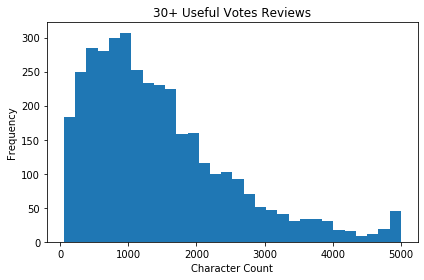

In [469]:
# plot distribution of character counts in useful reviews subset
text_length.plot(kind='hist', bins='fd', title='30+ Useful Votes Reviews')
plt.xlabel('Character Count')
plt.tight_layout()
plt.savefig('../img/useful_reviews_char_count.png')
plt.show()

# Data Pre-processing

In [4]:
# function that turns a sequence of length 100+1 into an input chunk (first 100 char) and target chunk (last 100 char).
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [5]:
# The unique characters in the file / number of output layer nodes.
vocab = sorted(set(text))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# converting text data into indices
text_as_int = np.array([char2idx[c] for c in text])

In [6]:
len(vocab) # checking character count

145

In [7]:
# create training and validation folds
text_as_int_tr = text_as_int[:int(text_as_int.shape[0]*.9)]
text_as_int_val = text_as_int[int(text_as_int.shape[0]*.9):]

In [8]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# options for saving checkpoints
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Model Architectures

## Monday Model / Simple GRU

### Shaping sample dimensions

In [9]:
# The maximum length sentence we want for a single input in characters
seq_length = 100

# Create training, validation examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int_tr)
char_dataset_val = tf.data.Dataset.from_tensor_slices(text_as_int_val)

# combine consecutive elements of a data set into batches
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
sequences_val = char_dataset_val.batch(seq_length+1, drop_remainder=True)

In [10]:
# use function to split sequences into input and target columns
dataset = sequences.map(split_input_target)
dataset_val = sequences_val.map(split_input_target)

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# group samples (input, target) into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

### Helper Functions

In [11]:
# loss function for neural net
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [12]:
# Simple GRU based on https://www.tensorflow.org/tutorials/text/text_generation
def build_model_simplegru(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      # embedding layer. ?? what does it do ??
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
      # GRU layer. return full sequence to output layer
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        return_sequences=True,
                        stateful=True
                        ),
      # output is a matrix of shape(seq length, vocab size)
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [13]:
# function to generate strings of variable length
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = num_generate

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = temperature

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
    
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

### Instantiate Model

In [14]:
# more efficient than adding layers method
model_simplegru = build_model_simplegru(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)
# print model architecture table
model_simplegru.summary()
# model needs to be compiled
model_simplegru.compile(optimizer='adam', loss=loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           37120     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 145)           148625    
Total params: 4,124,049
Trainable params: 4,124,049
Non-trainable params: 0
_________________________________________________________________


### Load Checkpoint Weights

In [15]:
model_simplegru.load_weights('../training_checkpoints/simpleGRU_training_checkpoints\\ckpt_15')

### Continue Training Model if Desired

In [99]:
# # number of passes over the data
# EPOCHS=30
# # fit model
# history = model_simplegru.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback], validation_data=dataset_val)

# Model Training Output

# Monday Model / SimpleGRU
Train for 842 steps  
Epoch 1/30  
842/842 [==============================] - 856s 1s/step - loss: 1.9921  
Epoch 2/30  
842/842 [==============================] - 858s 1s/step - loss: 1.4514  
Epoch 3/30  
842/842 [==============================] - 860s 1s/step - loss: 1.3572  
Epoch 4/30  
842/842 [==============================] - 836s 993ms/step - loss: 1.3080  
Epoch 5/30  
842/842 [==============================] - 831s 987ms/step - loss: 1.2742  
Epoch 6/30  
842/842 [==============================] - 837s 994ms/step - loss: 1.2484  
Epoch 7/30  
842/842 [==============================] - 830s 986ms/step - loss: 1.2276  
Epoch 8/30  
842/842 [==============================] - 831s 987ms/step - loss: 1.2109  
Epoch 9/30  
842/842 [==============================] - 831s 986ms/step - loss: 1.1973  
Epoch 10/30  
842/842 [==============================] - 825s 980ms/step - loss: 1.1865  
Epoch 11/30  
842/842 [==============================] - 822s 976ms/step - loss: 1.1778  
Epoch 12/30  
842/842 [==============================] - 820s 974ms/step - loss: 1.1712  
Epoch 13/30  
842/842 [==============================] - 817s 970ms/step - loss: 1.1671  
Epoch 14/30  
842/842 [==============================] - 816s 969ms/step - loss: 1.1644  
Epoch 15/30  
842/842 [==============================] - 808s 960ms/step - loss: 1.1634  
Epoch 16/30  
842/842 [==============================] - 818s 971ms/step - loss: 1.1635  
Epoch 17/30  
842/842 [==============================] - 808s 959ms/step - loss: 1.1659  
Epoch 18/30  
842/842 [==============================] - 810s 962ms/step - loss: 1.1708  
Epoch 19/30  
842/842 [==============================] - 813s 965ms/step - loss: 1.1781  
Epoch 20/30  
842/842 [==============================] - 809s 961ms/step - loss: 1.1855  
Epoch 21/30  
842/842 [==============================] - 807s 959ms/step - loss: 1.2153  
Epoch 22/30  
842/842 [==============================] - 807s 959ms/step - loss: 1.2153  
Epoch 23/30  
842/842 [==============================] - 808s 959ms/step - loss: 1.2193  
Epoch 24/30  
842/842 [==============================] - 806s 957ms/step - loss: 1.2577  
Epoch 25/30  
842/842 [==============================] - 814s 967ms/step - loss: 1.4293  
Epoch 26/30  
842/842 [==============================] - 803s 954ms/step - loss: 1.5127  
Epoch 27/30  
842/842 [==============================] - 804s 955ms/step - loss: 2.0795  
Epoch 28/30  
842/842 [==============================] - 802s 952ms/step - loss: 2.0716  
Epoch 29/30  
842/842 [==============================] - 801s 951ms/step - loss: 2.0330  
Epoch 30/30  
842/842 [==============================] - 794s 943ms/step - loss: 2.0158  

## Generating Text

### Checkpoint 15 (lowest training loss)

### Rebuild Model to accept batch size = 1 (single string input)

In [16]:
# rebuild model with batch size = 1
model_simplegru = build_model_simplegru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_simplegru.load_weights('../training_checkpoints/simpleGRU_training_checkpoints\\ckpt_15')
# ?? ??
model_simplegru.build(tf.TensorShape([1, None]))
# print model architecture table
model_simplegru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            37120     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 145)            148625    
Total params: 4,124,049
Trainable params: 4,124,049
Non-trainable params: 0
_________________________________________________________________


### Generate Text

In [458]:
%%time
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.6))
print(generate_text(model_simplegru, start_string=u"\n", num_generate=1400, temperature=0.6))


The staff is a warm cup of course the same turtlest of a property portion of food is the same. I have to say that it was their first time I paid it as well as the same for the table.  The people that were harded at a generous and relaxed to the customer service. I was totally worth it and asked if the guy should hit the cheapest menu. I was complemented on the walls while there was a solid 5 star rating with the artwork structures. We ended up having a beautiful Farmer's Blvd and professional and got the same thing about their farm to the pool table.  This is a big fast at the time I walk in. It has its own thing I don't really cannot miss the best treatment to start a shower but it is the love from a casual restaurant.  They are pretty good you can tell that they have to have to make a parking spot on my next tonight telling my child? 

If you are looking for some of the tiny company has the world and all of the desserts and their dish was so soft and good. I've been coming back agai

# Preparing Data for Classifier Model

### Generate wall of text to train a classifier

In [117]:
# function to generate block text of variable length
def generate_blocktext(model, start_string, num_generate=1000, temperature=0.6):
  # Evaluation step (generating text using the learned model)

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Here batch size == 1
  model.reset_states()
  print(start_string, end='')
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      print(idx2char[predicted_id], end='')

### This model generates characters at 90 chars/s, or roughly 1100 wpm. Plan accordingly.
(managed to generate 2748499 characters for training set. Until last complete sentence.)

In [112]:
%%time
generate_blocktext(model_simplegru, "Kin-Yip's Italian is amazing", 700, temperature=0.65)

 -- good prices... which is a big fan of sushi rice, which turned out to be a pretty place for the day. I thought it would have to say I enjoy the hostess that do not come back again and show good friends and for a friend who wants to be a party of How Clean food management.

I would say I have seated at a bar scanned.

When you can say possibly the same for the same time with a bar area, as well as the meat is amazing!  So many people try to sell in the restaurant. I enjoyed the chicken, several milkettes will discover a pastry bath loan options (so you can easily find the sliders and honestly, they don't have a blood ball sodas for everyone.  Also, I was so pleasantly surprised when the orWall time: 8.41 s


In [154]:
%%time
generate_blocktext(model_simplegru, "The Americano at Chul's is amazing", 700, temperature=0.65)

!
I of course I would say that it is a half mix and got a free meal and helpful. The waitress was a giant chocolate and salmon menu. They are fantastic and friendly and helpful.  The musical was the perfect temperature to what you pay for it.  You can advertise in the past trying to get a drink. 

The service was still the same professional that we wanted to spend the afternoon on my way to the strip.  It's a bit of a delivery stuff of how they've been speciality of the options on sentations. They are greeted by the air for the extra tortillas and the shredded dressing is the first time I was in Vegas as we enjoyed everything. I love the show and continues to the impressive space for every bWall time: 8.42 s


In [82]:
# %%time
# generate_blocktext(model_simplegru, '\n', 6314573, temperature=0.65)

# Import Generated Reviews and Get into DataFrame format

In [1]:
import codecs # allows different encoder options for reading-in text
from collections import Counter
from nltk.tokenize import sent_tokenize

In [2]:
# read-in text as single string
with codecs.open('../data/generated_reviews.txt', encoding='utf-8') as f:
    text_gen = f.read()

In [5]:
# tokenize by sentences
df_gen = pd.DataFrame({'text':sent_tokenize(text_gen)})

# add label column
df_gen['fake'] = 1

# Create Records from Real Reviews

In [9]:
# tokenize by sentences
df_real = pd.DataFrame({'text':sent_tokenize(text)})

# add label column
df_real['fake'] = 0

# Classification EDA Data Set (keep useful votes >= 30)

In [10]:
# concatenate real and fake reviews
df_classification = pd.concat([df_real, df_gen])

# sentence lengths
df_classification_str_len = df_classification.text.str.len()

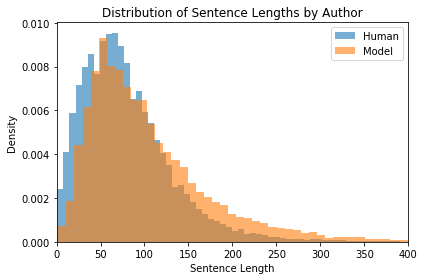

In [11]:
fig, ax = plt.subplots(tight_layout=True)
ax.hist(df_classification_str_len[df_classification.fake == 0], bins=400, alpha=0.6, label='Human', density=True)
ax.hist(df_classification_str_len[df_classification.fake == 1], bins=400, alpha=0.6, label='Model', density=True)
ax.set(title='Distribution of Sentence Lengths by Author', xlim=(0,400), xlabel='Sentence Length', ylabel='Density')
ax.legend()
plt.savefig('../img/real_fake_sent_len.png')
plt.show()

In [12]:
# count characters in real and fake text
text_char_count = Counter(text)
text_gen_char_count = Counter(text_gen)

# turn counts into dataframes
text_char_count = pd.DataFrame.from_dict(text_char_count, orient='index').sort_index()
text_gen_char_count = pd.DataFrame.from_dict(text_gen_char_count, orient='index').sort_index()

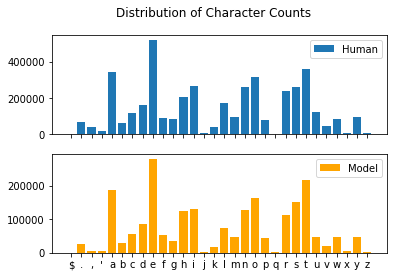

In [14]:
alphabet = ['$', '.', ',', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q' ,'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
fig, axes = plt.subplots(2,1, sharex=True)
fig.suptitle('Distribution of Character Counts')
axes[0].bar(alphabet, text_char_count.loc[alphabet, 0], label='Human')
axes[0].legend()
axes[1].bar(alphabet, text_gen_char_count.loc[alphabet, 0], color='orange', label='Model')
axes[1].legend()
plt.savefig('../img/real_fake_char_count.png')
plt.show()

# Classification Data Set

In [476]:
# minimum number of useful votes to include
# n = 30 # produces corpus for text generation (training for text generation)
n = 40 # produces largest corpus with comparable character count to generated (training for classification)

# number of reviews in subset
print(df_copy[df_copy.useful >= n].shape[0])

# number of characters in subset
print(len(df_copy[df_copy.useful >= n].text.str.cat(sep='\n')))

# block of text to serve as model training data
text = df_copy[df_copy.useful >= n].text.str.cat(sep='\n')

# dataframe to allow for eda plots
df = df_copy[df_copy.useful >= n]

# subset for eda plotting about comment characteristics
text_length = df.text.str.len()

1812
2782135


In [477]:
# tokenize by sentences
df_real = pd.DataFrame({'text':sent_tokenize(text)})

# add label column
df_real['fake'] = 0

In [478]:
# concatenate real and fake reviews
df_classification = pd.concat([df_real, df_gen])

In [494]:
df_classification.reset_index(inplace=True)

In [502]:
df_classification.to_json('../data/classification.json', orient='records', lines=True)

# Next Steps

Test the quality of generated reviews with classification models.

In [120]:
generate_blocktext(model_simplegru, "I had a fantastic time", 700, temperature=0.65)

I had a fantastic time and the company that is the first five star reviews in the best business and for its portions of staff on a magical explained to arrive, the people in 10 minutes to the point and I appreciate that the perfect shopper legacy can be sat to the full casual entrance at the end of the day was the best part of the strip. It's not even though I have to say I would recommend them to a store so now that you may find a plus for your order if you have a constant to enjoy a charce is so amazing. 

We have used to be a great experience at the surgery and they are doing and got back to the bar to park my landscaping place. It was nothing less terrified and proper second favorite bar is at least 4 minutes